# Table of contents
1. [Libraries](#libraries)
2. [Question](#quesion)
3. [Data Preparation](#preparation)
4. [Modelling](#modelling)
5. [Evaluation](#evaluation)

<h1 id ="libraries">1. Libraries </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression


<h1 id = "question">2. Question </h1>

**A question:** Predict the gross of movies

**Answering this question will help us:**

<h1 id = 'preparation'>3. Data Preparation </h1>

In [2]:
data = pd.read_csv('../Data/preprocessed_data.csv')

In [3]:
data['Total Gross'] = data['Worldwide Gross'] + data['Domestic Gross']

- Check the null values of economic column

In [4]:
data.loc[data['Title'] == 'BenHur: A Tale of the Christ', 'Production Budget'] = 15000000
data.loc[data['Title'] == 'BenHur: A Tale of the Christ', 'Total Gross'] = 3900000

data.loc[data['Title'] == 'Wings', 'Production Budget'] = 2000000
data.loc[data['Title'] == 'Wings', 'Total Gross'] = 1750000

data.loc[data['Title'] == 'The Big Parade', 'Production Budget'] = 382000
data.loc[data['Title'] == 'The Big Parade', 'Total Gross'] = 22000000


- Check for skewness

In [5]:
# Check the skewness of production budget and worldwide/domestic gross
print('Production Budget: ',data['Production Budget'].skew())
print('Worldwide Gross: ', data['Worldwide Gross'].skew())
print('Domestic Gross: ', data['Domestic Gross'].skew())
print('Total Gross: ', data['Total Gross'].skew())

Production Budget:  2.716845989217062
Worldwide Gross:  4.833655536153712
Domestic Gross:  3.845856866276893
Total Gross:  4.528601604463278


As can be seen, the skewness in 3 economic features is heavily positively skewed, therefore we need to **log transform** these features. 

However, before log transform we will need to multiply the inflation rate of each year to have the accurate calculation and analysis

- Multiply the inflation rate

In [6]:
# Read the inflation data into a DataFrame
inflation_data = pd.read_csv('../Data/inflation_rate.csv')

# Create DataFrame for inflation data
inflation_df = pd.DataFrame(inflation_data)

data['Year'] = pd.to_datetime(data['Release Date']).dt.year

# Merge inflation data with your movie data on 'Year'
data = data.merge(inflation_df, on='Year', how='left')

# Adjust the economic columns by dividing them by the 'Unit' (inflation adjustment factor)
economic_features = ['Production Budget', 'Domestic Gross', 'Worldwide Gross', 'Total Gross']

for feature in economic_features:
    data[feature] = data[feature] * (data['Unit'] / data['Unit'].iloc[-1])

# The adjusted columns will now reflect the true values after inflation adjustment

- Apply log transformation

In [7]:
data['Production Budget'] = (data['Production Budget'] + 1).apply(np.log)
data['Worldwide Gross'] = (data['Worldwide Gross'] + 1).apply(np.log)
data['Domestic Gross'] = (data['Domestic Gross'] + 1).apply(np.log)
data['Total Gross'] = (data['Total Gross'] + 1).apply(np.log)

In [8]:
# Check the skewness of production budget and worldwide/domestic gross
print('Production Budget: ',data['Production Budget'].skew())
print('Worldwide Gross: ', data['Worldwide Gross'].skew())
print('Domestic Gross: ', data['Domestic Gross'].skew())
print('Total Gross: ', data['Total Gross'].skew())

Production Budget:  -1.241663317451469
Worldwide Gross:  -2.3151114555660994
Domestic Gross:  -1.9259857971548238
Total Gross:  -2.3703920346053122


After the transformation, the features now exhibit negative skewness, which is still acceptable for many regression models.

- One hot encoding for **`Genres`** and **`Rating`**

In [9]:
import ast
# One-hot encode the genre column
data['Genre'] =  data['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else None)

# Drop rows with missing values in the 'Genre' column
data = data.dropna(subset=['Genre'])

# One-hot encode the 'Genre' column and retain "Genre_" as a prefix
genre_dummies = data['Genre'].str.join('|').str.get_dummies()
genre_dummies.columns = ['Genre_' + col for col in genre_dummies.columns]  # Add "Genre_" prefix

# Merge the one-hot encoded genres back into the dataframe
data = data.drop('Genre', axis=1).join(genre_dummies)

# One-hot encode the MPAA Rating column
data = pd.get_dummies(data, columns=['Rating'], dtype=int)

# One-hot encode the Studio column
data = pd.get_dummies(data, columns=['Studio'], dtype=int)

In [10]:
data['Mean UserScore'] = (data['Tomatoes UserScore']+data['Meta UserScore'])/2
data['Mean CriticScore'] = (data['Tomatoes CriticScore']+data['Metascore'])/2

data['Year'] = pd.to_datetime(data['Release Date']).dt.year
data['Month'] = pd.to_datetime(data['Release Date']).dt.month

X_train, X_test, y_train, y_test = train_test_split(data.drop('Total Gross', axis=1), data['Total Gross'], test_size=0.2, random_state=0)

X_train = X_train[y_train.notna()]
y_train = y_train[y_train.notna()]


- **`Cast and Director`**
    - As the domain information collected, the cost of these features are already included in **`Production Budget`**, therefore, we can remove these columns out of our current data

In [11]:
data.drop(columns=['Cast', 'Director'])

,Title,Tomatoes CriticScore,Tomatoes UserScore,Release Date,Production Budget,Domestic Gross,Worldwide Gross,Metascore,Meta UserScore,Total Gross,...,Studio_Zephyr Films,"Studio_Zion Films, Inc.",Studio_eOne Films,Studio_here! Films,Studio_root,Studio_truTV,Studio_unafilm,Mean UserScore,Mean CriticScore,Month
0,L.A. Confidential,99.000000,94.00000,1997-09-19,17.980850,18.593793,19.263409,91.0000,86.000000,19.676780,...,0,0,0,0,0,0,0,90.00000,95.000000,9
1,The Godfather,97.000000,98.00000,1972-03-15,17.702056,20.672324,21.354595,100.0000,93.000000,21.763699,...,0,0,0,0,0,0,0,95.50000,98.500000,3
2,Casablanca,99.000000,95.00000,1943-01-23,16.686983,18.996521,19.006477,100.0000,87.000000,19.694659,...,0,0,0,0,0,0,0,91.00000,99.500000,1
3,Parasite,99.000000,90.00000,2019-05-30,16.428409,17.937554,19.494757,97.0000,89.000000,19.685976,...,0,0,0,0,0,0,0,89.50000,98.000000,5
4,Top Gun: Maverick,96.000000,99.00000,2022-05-20,18.951309,20.393000,21.104712,78.0000,84.000000,21.504027,...,0,0,0,0,0,0,0,91.50000,87.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,Antarctic Edge: 70 South,57.000000,50.00000,2015-04-17,12.146250,9.108828,9.108828,62.0000,67.400000,9.801920,...,0,0,0,0,0,0,0,58.70000,59.500000,4
5102,8 Days to Hell,58.367886,62.45744,2021-07-30,11.576056,0.000000,0.000000,55.6051,64.939799,0.000000,...,0,0,0,0,0,0,0,63.69862,56.986493,7
5103,20 Dates,35.000000,47.00000,1999-02-26,11.664962,13.769894,13.877084,35.0000,56.400000,14.518071,...,0,0,0,0,0,0,0,51.70000,35.000000,2
5104,Happy 40th,58.367886,62.45744,2015-03-01,10.690980,0.000000,0.000000,55.6051,64.939799,0.000000,...,0,0,0,0,0,0,0,63.69862,56.986493,3


- Feature selection for numerical columns

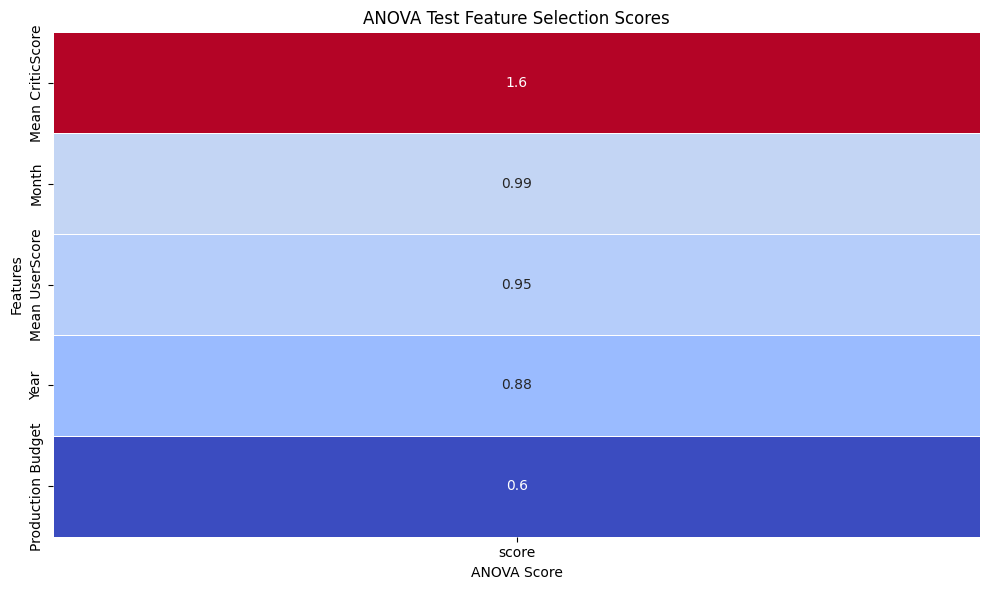

In [12]:
from sklearn.feature_selection import f_classif


numerical_columns = ['Production Budget', 'Mean UserScore', 'Mean CriticScore', 'Year', 'Month']
X_numerical = X_train[numerical_columns]  # Use column names directly

# Fit SelectKBest with chi2
selector = SelectKBest(f_classif, k=3)
selector.fit(X_numerical, y_train)

# Get Chi2 scores
scores = pd.DataFrame(data=selector.scores_, index=numerical_columns, columns=['score'])
scores = scores.sort_values(by='score', ascending=False)

# Plotting the scores using a barplot
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('ANOVA Test Feature Selection Scores')
plt.xlabel('ANOVA Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Since **`Mean CriticScore`**, **`Month`** and **`Mean UserScore`** have high values, so we will use it form modelling

- Feature selection for categorical columns

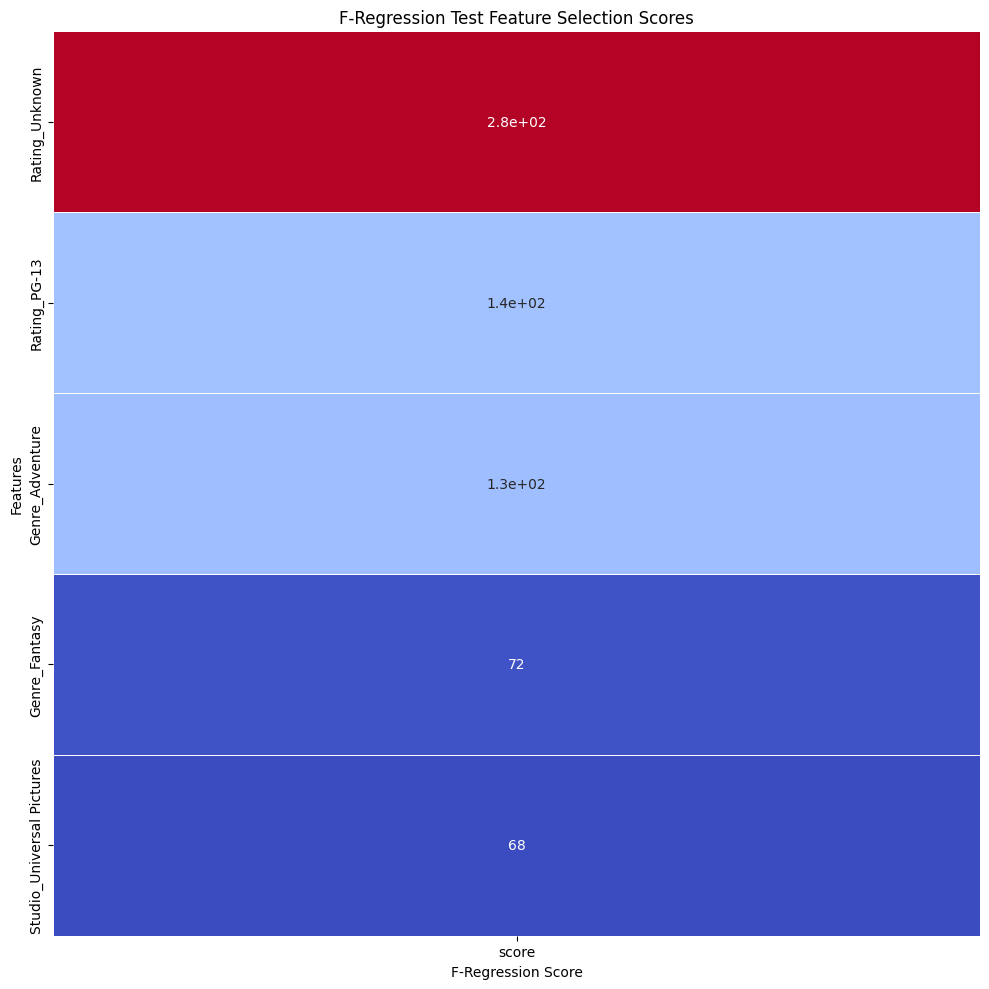

In [13]:
# # Loại bỏ các hàng trong X_train và y_train mà y_train chứa NaN

# Get all genre columns
genre_columns = [col for col in X_train.columns if 'Genre' in col]

# Get all rating columns
rating_columns = [col for col in X_train.columns if 'Rating' in col]

studio_columns = [col for col in X_train.columns if 'Studio' in col]

# Put all genre and rating columns together
categorical_columns = genre_columns + rating_columns + studio_columns

X_categorical = X_train[categorical_columns]  # Use column names directly
X_categorical = X_categorical.fillna(0)

# Fit SelectKBest with chi2
selector = SelectKBest(f_regression, k=5)
selector.fit(X_categorical, y_train)

# Get Chi2 scores
scores = pd.DataFrame(data=selector.scores_, index=categorical_columns, columns=['score'])
scores = scores.sort_values(by='score', ascending=False)

# Get the top 5 categorical features
top_5_categorical = scores.index[:5].tolist()

# Plotting the scores using a barplot
plt.figure(figsize=(10, 10))
sns.heatmap(scores.head(5), annot=True, cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('F-Regression Test Feature Selection Scores')
plt.xlabel('F-Regression Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


As can be seen from the plot, some members of 3 chosen categorical columns shows up in top 5 F-Regression Score, therefor we will need to include all these columns for modelling

In [14]:
X_train = X_train[numerical_columns + categorical_columns]
X_test = X_test[numerical_columns + categorical_columns]

<h1 id ="modelling">4. Modelling </h1>

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

- XGBoost

In [16]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
pipeline_xgb = Pipeline(steps=[('scaler', StandardScaler()), ('model', xgb)])
pipeline_xgb.fit(X_train, y_train)
# Using k-fold cross-validation to evaluate the model
y_pred = pipeline_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('MSE: ', mse)
print('R2: ', r2)
print('MAE: ', mae)


MSE:  11.467656258223657
R2:  0.4492656170387286
MAE:  1.8787186910236067


- XGBoost with GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np

# Define the model
xgb = XGBRegressor(random_state=0, objective='reg:squarederror')

# Create the pipeline
pipeline_xgb = Pipeline(steps=[('scaler', StandardScaler()), ('model', xgb)])

# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter grid with random distributions
param_dist = {
    'model__n_estimators': [100, 200, 500],
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': [3, 5, 7],
    'model__subsample': uniform(0.7, 0.3),
    'model__colsample_bytree': uniform(0.7, 0.3),
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [0, 0.1]
}

# Run RandomizedSearchCV with 5 iterations
random_search = RandomizedSearchCV(pipeline_xgb, param_distributions=param_dist, n_iter=5, cv=3, scoring='neg_mean_squared_error', verbose=1)
random_search.fit(X_train, y_train)


# Best parameters found by GridSearchCV
print("Best Hyperparameters: ", random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_

# Use k-fold cross-validation to evaluate the model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE scores: {cv_scores}')
print(f'Mean Cross-Validation MSE: {np.mean(cv_scores)}')

# Using the model to predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('Test MSE: ', mse)
print('Test R2: ', r2)
print('Test MAE: ', mae)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters:  {'model__colsample_bytree': 0.8434229951084112, 'model__learning_rate': 0.03322664705781082, 'model__max_depth': 5, 'model__n_estimators': 500, 'model__reg_alpha': 0, 'model__reg_lambda': 0.1, 'model__subsample': 0.9894814746931637}
Cross-Validation MSE scores: [-12.25800207 -11.59620658 -12.98642509 -14.08812392 -12.30526846]
Mean Cross-Validation MSE: -12.646805223192347
Test MSE:  11.344477133054301
Test R2:  0.4551812965783213
Test MAE:  1.8646733369946173


- Decision Tree Regressor

In [ ]:
dcs = DecisionTreeRegressor(random_state=0)
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', dcs)])
pipeline.fit(X_train, y_train)
# Using k-fold cross-validation to evaluate the model
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('MSE: ', mse)
print('R2: ', r2)
print('MAE: ', mae)

MSE:  20.403991510278388
R2:  0.020097967594572053
MAE:  2.372480506249262
